# Import libs

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable
from skimage.measure import compare_psnr
import pickle
import operator

import utils
from model import create_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

# Load image

## Motivation behind the selection of the image
In denoising we want to test if NN can help us to learn useful features about the underlying image. If that happens we can stop the learning early enough to make sure that the network won't learn any unwanted features from the corrupted image. In this case image is corrupted with generated noise. Image is also blurry. Our goal is to see if generated noise can be removed with early stopping and also we want to see if we can make the image sharper.

# Get model

In [2]:
def get_model(input_depth=3, output_depth=3, pad='zero'):
        net = create_model(downsample_channels = [128, 128, 128, 128, 128],
                    upsample_channels = [128, 128, 128, 128, 128],
                    skip_channels = [4, 4, 4, 4, 4],
                    input_channel_size = input_depth,
                    output_channel_size = output_depth,
                    upsample_mode='bilinear',
                    activation_function=nn.LeakyReLU(0.2, inplace=True),
                    padding_type=pad
                   ).type(dtype)

        return net

def get_net_input(img_size, input_depth=3, INPUT="noise"):
    return utils.get_noise(input_depth, INPUT, (img_size[1], img_size[0])).type(dtype).detach()

# Evaluate model

In [3]:
def evaluate_model(net, net_input, img_np, img_noisy_np, num_iter=6000,
                   show_every=500, report=True, figsize=10):
 
    loss_fn=torch.nn.MSELoss().type(dtype)
    input_noise=True
    LR=0.01
    reg_noise_std=1./30.
    
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    img_noisy_var = utils.np_to_var(img_noisy_np).type(dtype)
    
    psnr_history = []

    def closure(i):
        if input_noise:
            net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)
        total_loss = loss_fn(out, img_noisy_var)
        total_loss.backward()

        psrn = compare_psnr(utils.var_to_np(out), img_np)
        psnr_history.append(psrn)
        
        if report:
            print ('Iteration %05d    Loss %f   PSNR %.3f' % (i, total_loss.data[0], psrn), '\r', end='')
            if  i % show_every == 0:
                out_np = utils.var_to_np(out)
                utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

        return total_loss

    print('Starting optimization with ADAM')
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    for j in range(num_iter):
        optimizer.zero_grad()
        closure(j)
        optimizer.step()
        
    if report:
        out_np = utils.var_to_np(net(net_input))
        q = utils.plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);
        
        data = {}
        data['psnr_history'] = psnr_history
        pickle.dump(data, open('denoising_psnr.p','wb'))

    max_index, max_value = max(enumerate(psnr_history), key=operator.itemgetter(1))
    return max_index, max_value

## MAIN TEST

#### Original and corrupted image

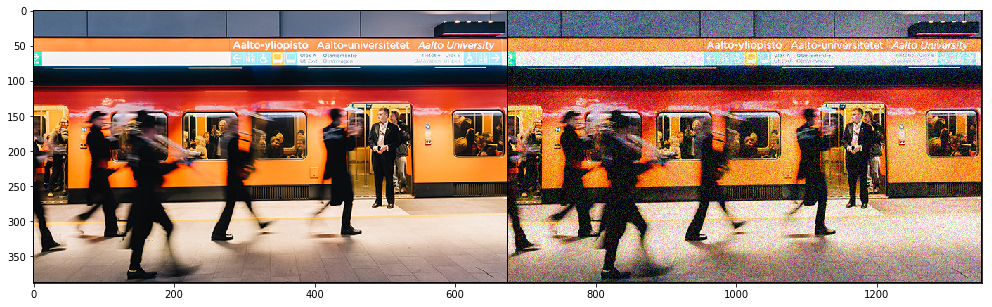

In [4]:
fname = 'data/denoising/metro_aalto.jpg'
img_np, img_noisy_np = utils.get_original_and_corrupted_image(fname)
utils.plot_image_grid([img_np, img_noisy_np], 10, 15);

### Model and training

In [ ]:
#net = get_model()
#initial_input = get_net_input((img_np.shape[2], img_np.shape[1], img_np.shape[0]))
#max_iteration, max_psnr = evaluate_model(net, initial_input, img_np, img_noisy_np, report=True)

## Test model with 100 random images

layer 0
layer 1
layer 2
layer 3
layer 4
Starting optimization with ADAM


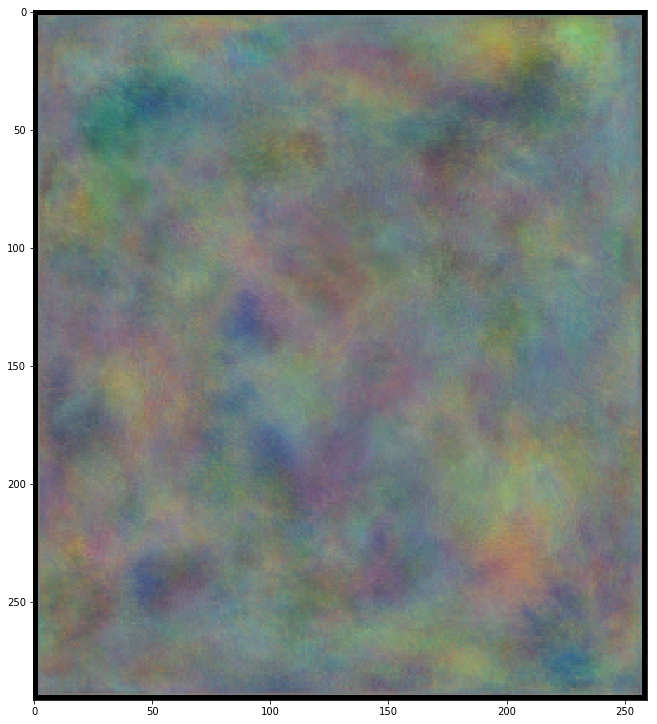

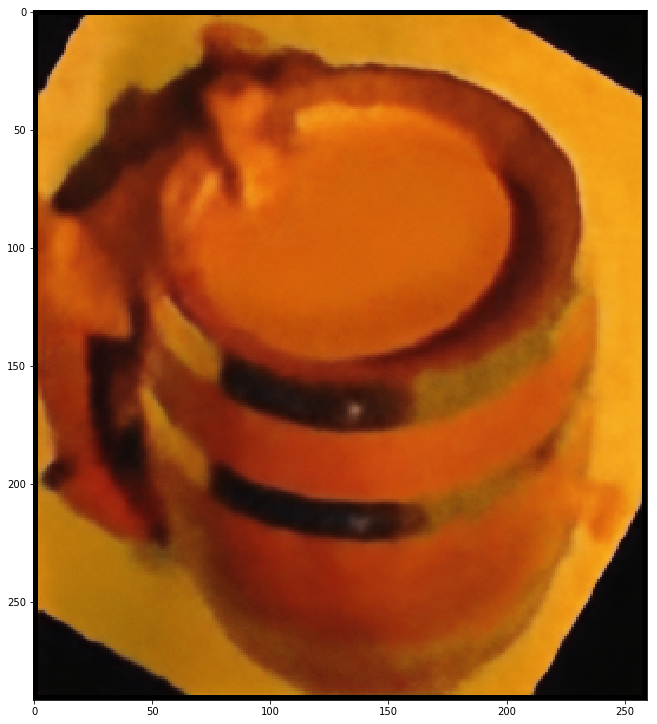

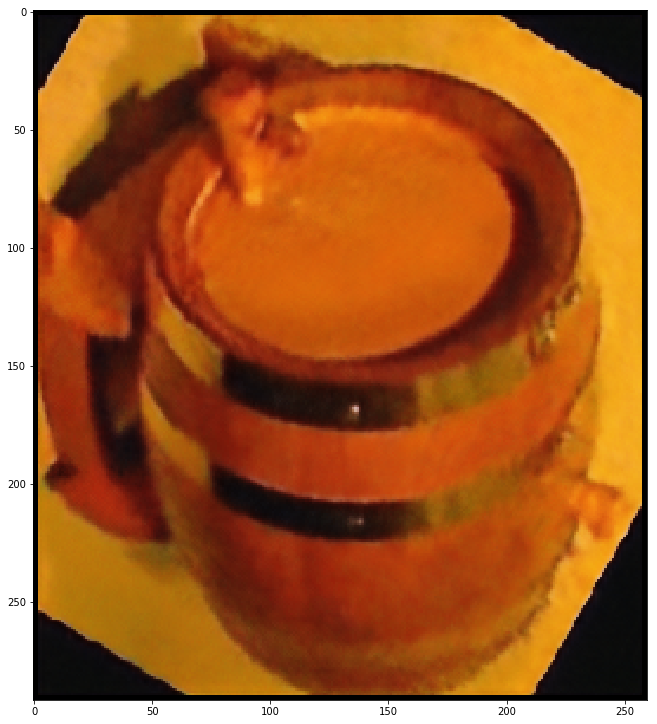

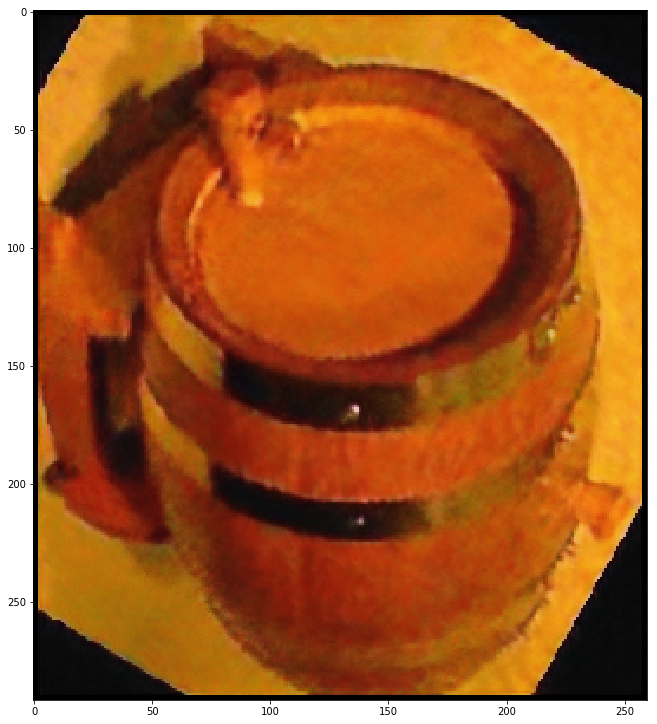

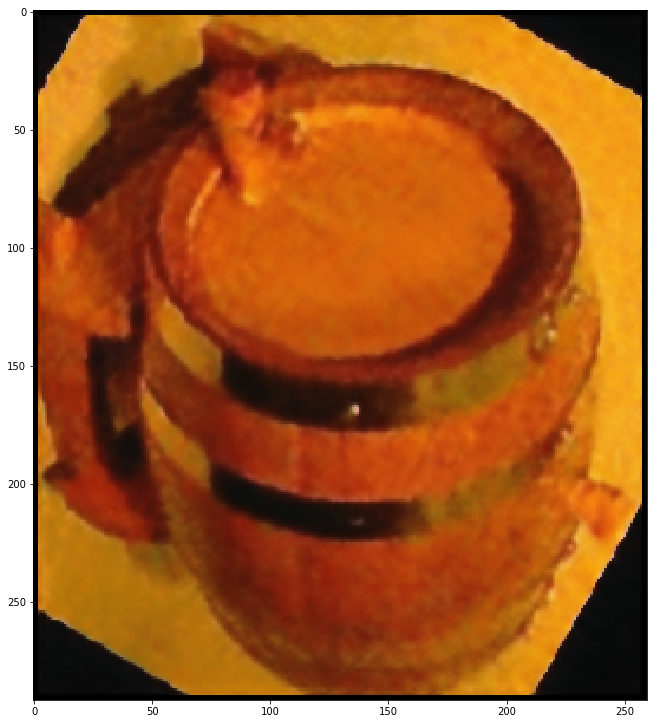

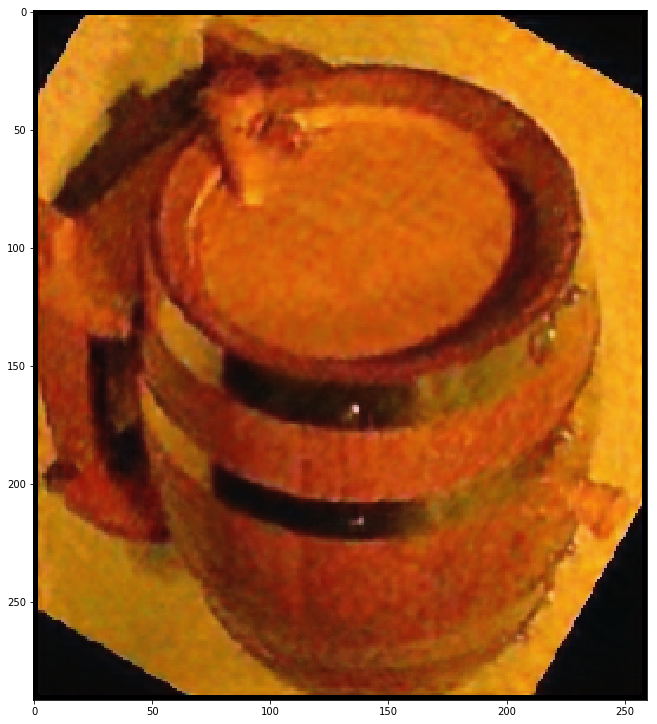

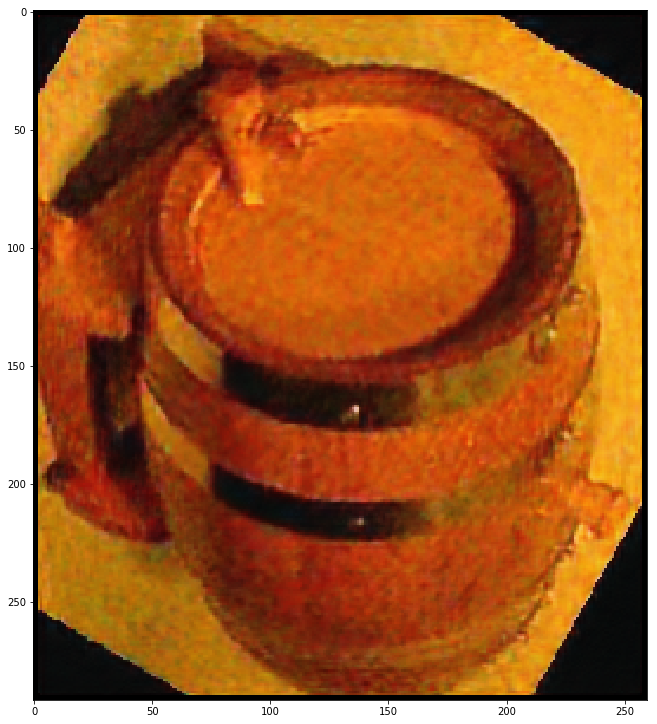

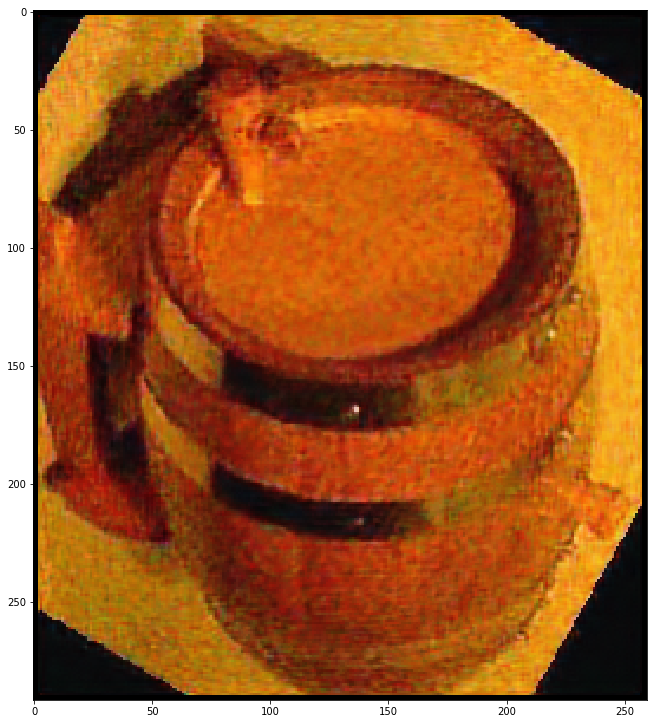

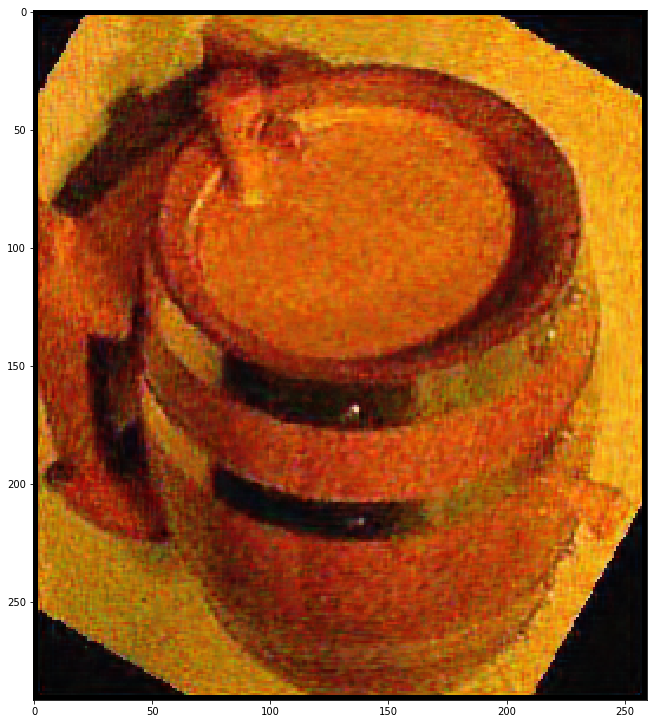

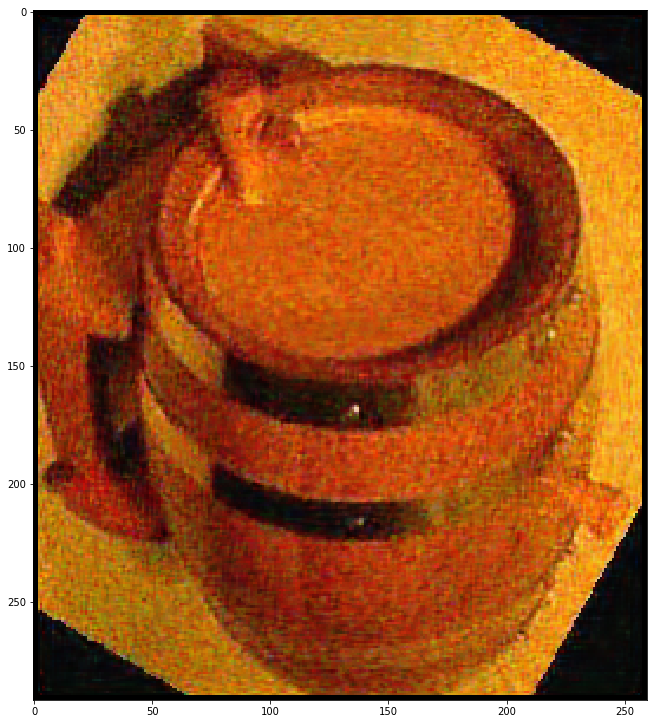

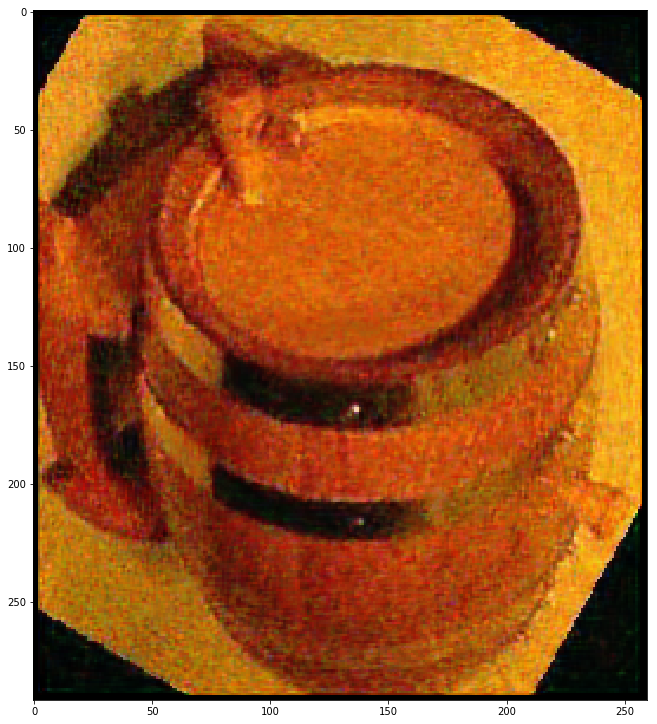

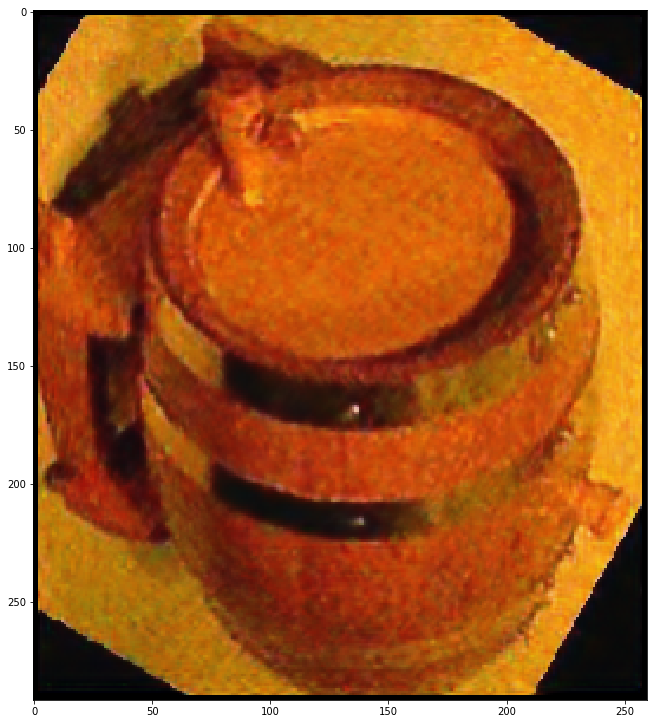

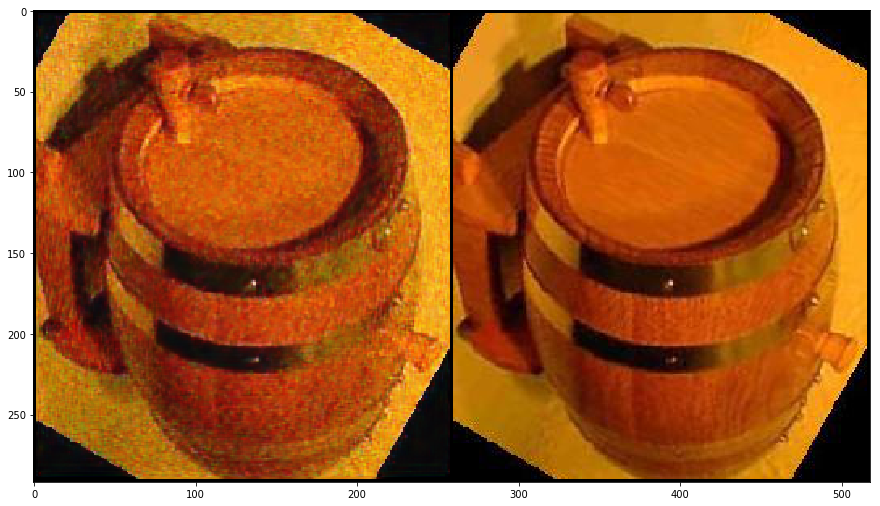

layer 0
layer 1
layer 2
layer 3
layer 4
Starting optimization with ADAM


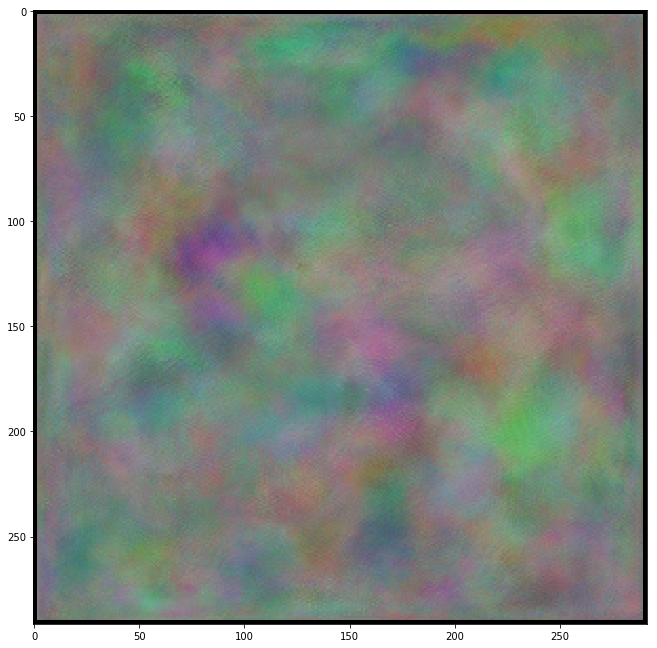

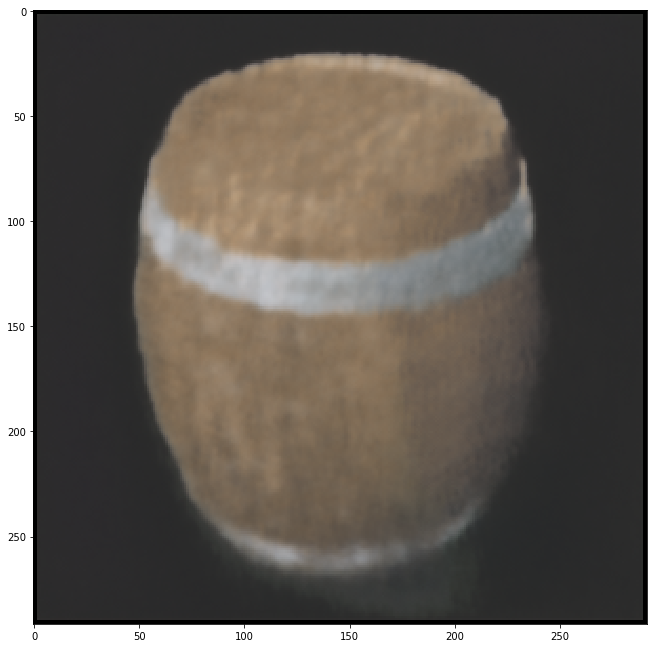

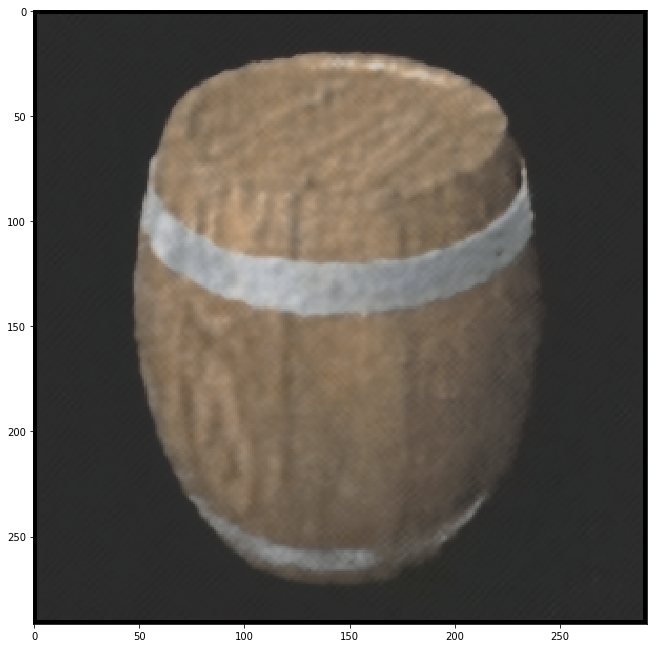

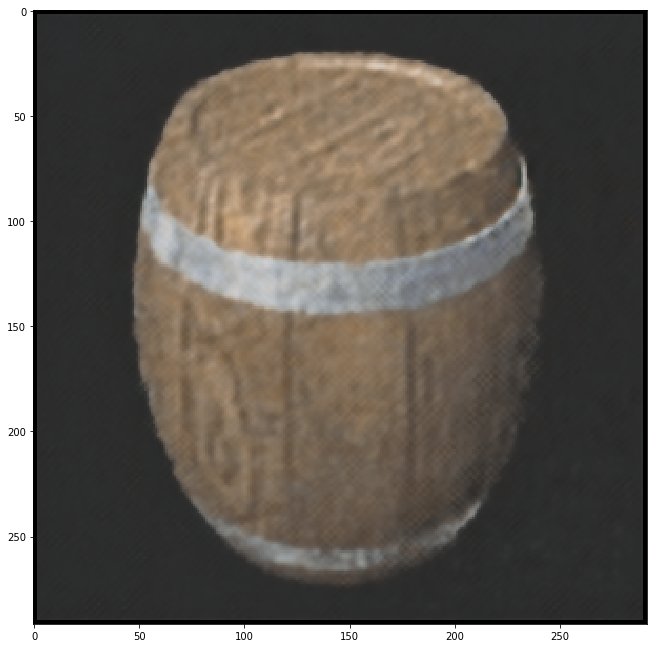

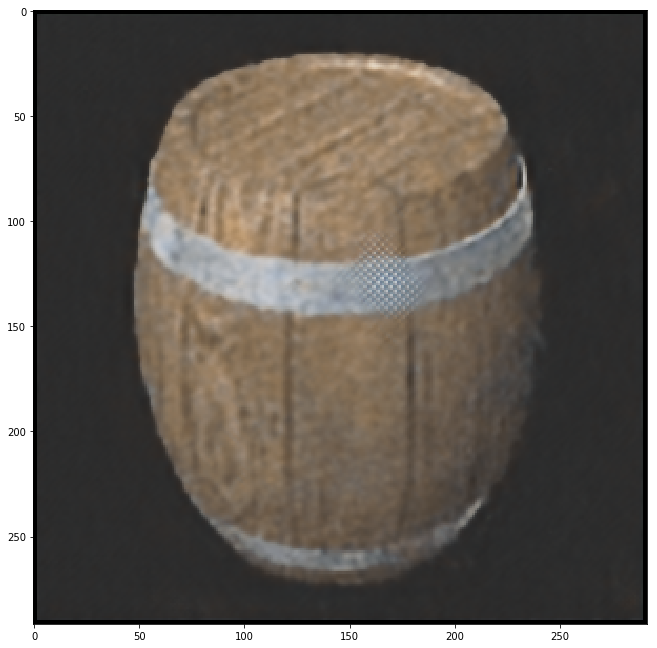

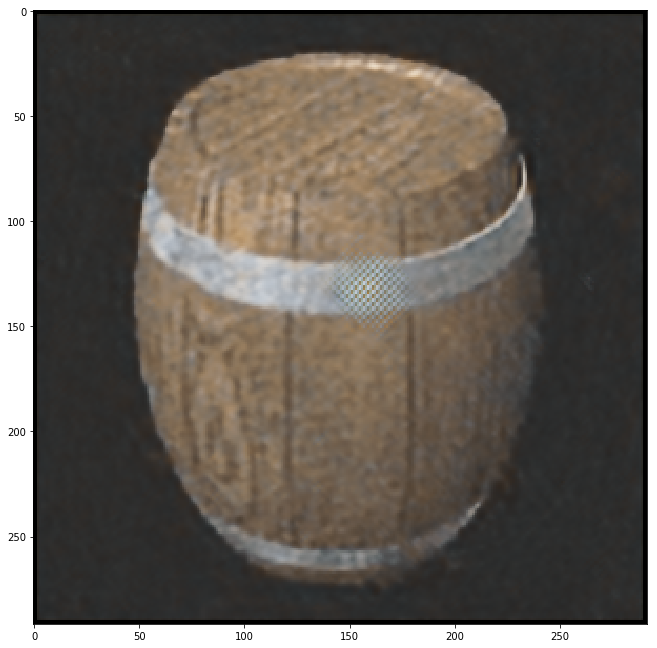

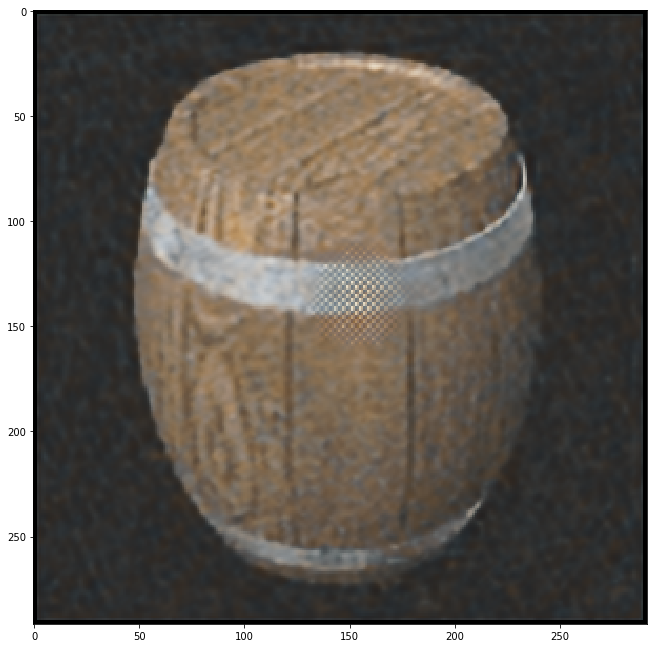

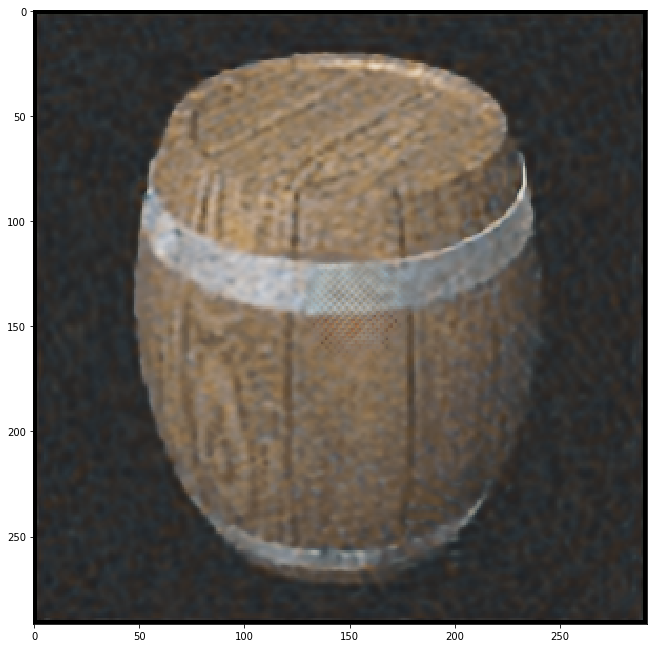

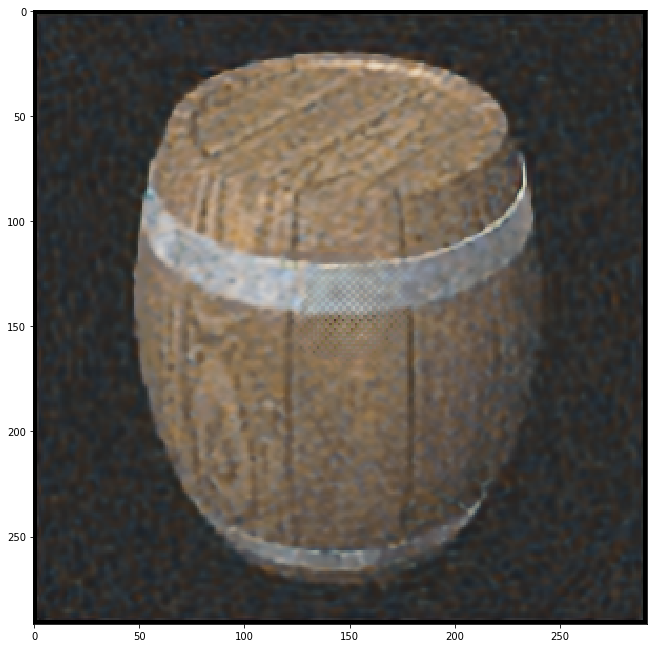

In [ ]:
picture_paths = utils.get_picture_randomly(n=2)

data = {'max_psnrs': [], 'iteration': []}

for path in picture_paths[0]:
    img_np, img_noisy_np = utils.get_original_and_corrupted_image(path)
    net = get_model(output_depth=img_np.shape[0])
    initial_input = get_net_input((img_np.shape[2], img_np.shape[1], img_np.shape[0]))
    max_iteration, max_psnr = evaluate_model(net, initial_input, img_np, img_noisy_np, report=True)
    
    utils.save_statistics({path: [max_iteration, max_psnr]}, 'denoising_psnr_imageset.p')
    
    